# Import modules

In [30]:
import pandas as pd 
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tqdm.keras import TqdmCallback
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [1]:
from utilities import deets
from choices import get_train_data , param_dict
classes = ['AGN' ,'STAR' , 'YSO' ,  'CV' , 'LMXB' , 'HMXB' ,'ULX','PULSAR']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }
ret_dict =  {
    'clf' : False , 
    'prob_table' : True , 
    'acc' : True , 
    'pr_score' : True , 
    'precision' : True , 
    'recall' : True , 
    #'recall' : True ,
}

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938


In [2]:
file = f'compiled_data_v3/imputed_data/x_phot_with_color_minmax_modeimp.csv'
train_data = get_train_data(flags = flag, classes= classes , offset = 1, file=file , ret_id_cols=['class' , 'significance'])
#cols_to_drop = param_dict['hardness']+param_dict['hard_var_col']+param_dict['sparse_col']
cols_to_drop = param_dict['hardness']
train_data = train_data.drop(columns = cols_to_drop)
deets(train_data,1)


offset:  	0.000|1.010
singinficance:  1.000|267.938
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 47
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


In [3]:
x_train , y_train , sig = train_data.drop(columns=['class' ,'significance']) , train_data[['class']] , train_data['significance']


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(x_train)

In [5]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train_oh = encoder.fit_transform(y_train)
y_train_oh


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [6]:
def plot(history):
    fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize= (12,4))

    ax[0].plot(history.history['accuracy'] , color='crimson')
    ax[0].plot(history.history['val_accuracy'] , color='black')
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(history.history['loss'] , color='crimson')
    ax[1].plot(history.history['val_loss'] , color='black')
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    #p#lt.show()

In [37]:
def get_model(xt ,yt):
    inputs = keras.Input(shape=(xt.shape[1],))
    #x = layers.BatchNormalization()(inputs)
    #x = layers.Activation("sigmoid")(inputs)
    x = layers.LayerNormalization()(inputs)
    #x = layers.Conv1D(32,3 , input_shape = (xt.shape[1],))(x)
    #x = layers.GaussianNoise(0.3)(x)
    #x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x_mid = layers.Dense(32, activation='relu')(x)
    x_mid = layers.LayerNormalization()(x_mid)
    x_mid = layers.Dense(16, activation='relu')(x)
    x = layers.GaussianNoise(0.4)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.GaussianNoise(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(rate = 0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(inputs)
    #x = layers.Dropout(rate = 0.3)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x_mid = layers.Dropout(rate = 0.8)(x_mid)
    x = layers.Dense(16, activation='relu')(x)
    #x = layers.Dropout(rate = 0.3)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    output = layers.Dense(yt[0].shape[0] , activation='softmax')(x)
    model = keras.Model(inputs=inputs , outputs = output)
    return model


 17%|█▋        | 173/1000 [00:55<04:27,  3.09epoch/s, loss=0.6, accuracy=0.797, val_loss=0.704, val_accuracy=0.786]  


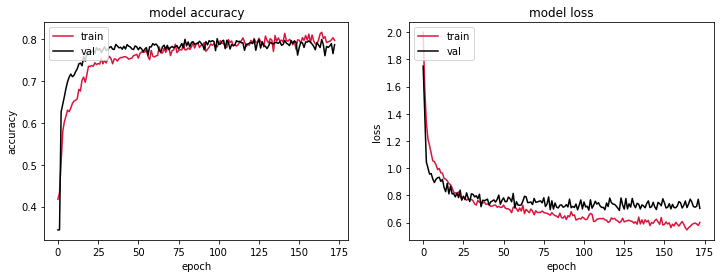

In [38]:
model = get_model(x_train_pca , y_train_oh)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
mc = ModelCheckpoint('models/fc_net_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model.fit(x_train_pca , y_train_oh ,
    verbose=0 , validation_split=0.8,epochs=1000 , callbacks=[es, mc, TqdmCallback(verbose=0)] , 
    )
plot(history)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn. import svm
model = GradientBoostingClassifier()
model  = svm()


ModuleNotFoundError: No module named 'sklearn.SVC'

In [ ]:
y_train = y_train['class']


In [ ]:
model.fit(x_train , y_train)


GradientBoostingClassifier()

In [ ]:
from sklearn.model_selection import train_test_split
xt,xv , yt,yv = train_test_split(x_train , y_train , stratify = y_train ,  test_size = 0.2)

In [ ]:
model.fit(xt,yt)


AttributeError: 'GradientBoostingClassifier' object has no attribute 'evaluate'

In [ ]:
model.score(xv,yv)

0.9123945489941596